# Ecolab3 demo

Ecolab3 was based on Mike Croucher's python version and Dawn Walker's original MATLAB version. This one has a few additions, such as regrowing grass, etc.

This notebook just shows how to use the default ecolab3. There are some parameters you can access through the constructors, while others you might need to edit the agent.py or environment.py. Later you'll want to edit the actual methods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ecolab3.environment import Environment
from ecolab3.agents import Rabbit, Fox
from ecolab3 import run_ecolab, draw_animation, get_agent_counts

In [2]:
#create default environment
env = Environment(shape=[40,40],growrate=50,maxgrass=5,startgrass=1)
    
#create agents (rabbits and foxes)
Nrabbits = 40
Nfoxes = 10
agents = []
for i in range(Nrabbits):
    r = Rabbit(position=env.get_random_location(),speed=1)
    agents.append(r)
for i in range(Nfoxes):
    f = Fox(position=env.get_random_location(),speed=5)
    agents.append(f)

In [3]:
#run the simulation (default = 1000 iterations)
record = run_ecolab(env,agents)

In [4]:
#If you want to save your data, use this:
#import pickle
#pickle.dump(record,open('myrecord.pkl','wb'))

#to load it later, use this:
#record = pickle.load(open('myrecord.pkl','rb')) 

<IPython.core.display.Javascript object>


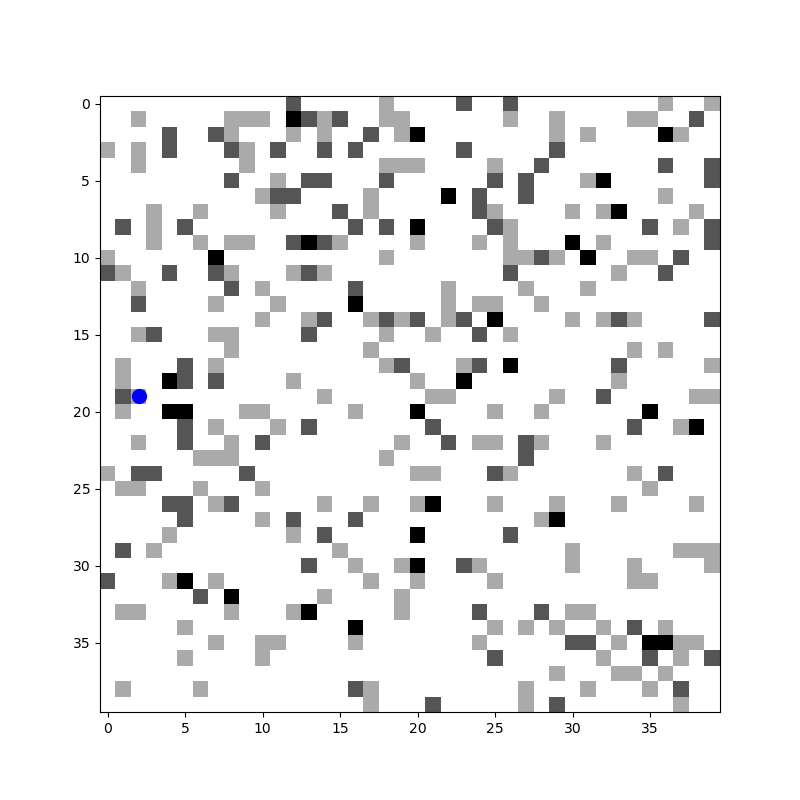

In [5]:
#need to use %matplotlib notebook, calling twice avoids a bug.
%matplotlib notebook 
%matplotlib notebook
fig = plt.figure( figsize=(8,8) )
anim = draw_animation(fig,record[::3]) #draw every 3rd record

#uncomment this line if you want to save animation to file.
#anim.save('test_anim.mp4', fps=20, extra_args=['-vcodec', 'libx264'])

We might want to just look at general statistics, e.g. how the number of rabbits and foxes fluctuates

Traceback (most recent call last):
  File "/home/mike/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/home/mike/anaconda3/lib/python3.8/site-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


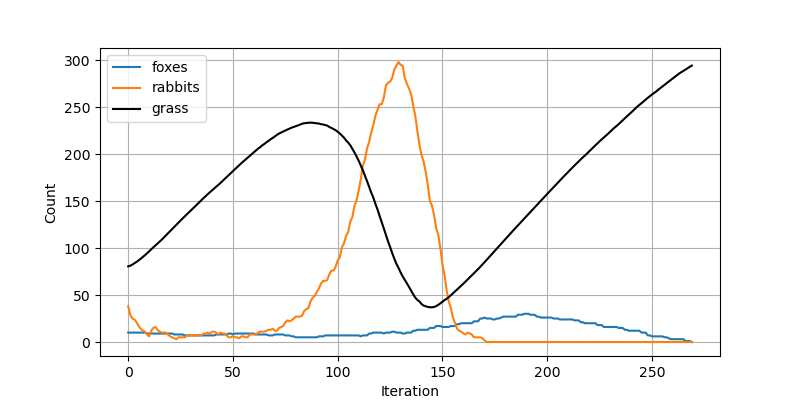

In [6]:
%matplotlib notebook

%matplotlib notebook
counts = get_agent_counts(record)
plt.figure(figsize=[8,4])
plt.plot(counts[:,0],label='foxes')
plt.plot(counts[:,1],label='rabbits')
plt.plot(counts[:,2]/20,'k-',label='grass') #/20 to get on same scale
plt.legend()
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Count');

1) Most times I've run this it seems the grass grows considerably, then the rabbits suddenly grow, the foxes grow in response. The grass is eaten. Then the combined effect of less grass and more foxes causes the rabbit population to drop to zero. (sometimes other things happen, like the fox population doesn't survive initially)

2) What happens if the foxes are less good predators (reduce their speed from 5 to 2 or 3?)? Explain?

3) What happens if there are no foxes?

4) There are a lot of parameters to play with. You should also start exploring the code (agents.py and environment.py) to see what you can alter to get different behaviour.

Note: Although it's tempting to think that oscillations are Lotka-Volterra (Predator-Prey) interactions between the rabbits and the foxes, it might be that they are caused by grass-rabbit iteractions. The plot of the grass count reveals this might be the case...